In [197]:
import pyupbit
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from functools import reduce

pd.set_option('display.max_row', 1460)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings(action='ignore')

In [215]:
def get_high_price(df, idx, term): 
    test_price = df.iloc[idx].high
    df_test = df[idx - term: idx].high
    price_ordering = []
    
    for price in df_test:
        if price > test_price:
            return False
        
        price_ordering.append(price)
        
    return max(price_ordering)


def get_low_price(df, idx, term):
    test_price = df.iloc[idx].low
    df_test = df[idx - term: idx].low
    price_ordering = []

    for price in df_test:
        if price < test_price:
            return False

        price_ordering.append(price)

    return min(price_ordering)

    

def exit_position(df, position, idx, term):
    exit_price = None
    if position == 1:
        exit_price = get_low_price(df, idx, term)
        
    elif position == 2:
        exit_price = get_high_price(df, idx, term)
    
    return exit_price


def set_return_rate(x):
    result = None

    if x.position == 1:
        if x.position_price:
            result = (x.close / x.position_price)
        else:
            result = x.close / x.open
            
    elif x.position == 2:
        if x.position_price:
            result = x.position_price / x.close 
        else:
            result = x.open / x.close
    else:
        result = 1
        
    return result


def each_turtle_backtest(ticker, to, count, enter_term, exit_term):
    df = pyupbit.get_ohlcv(ticker=ticker, interval="1d", to=to, count=count)

    position = 0
    position_list = []
    position_price_list = []

    for idx, data in enumerate(df.itertuples()):
        if idx < params[-1][0]:
            position_list.append(position)
            position_price_list.append(None) 
            continue

        elif position:
            if result:= exit_position(df, position, idx, exit_term):
                position = 0
                position_list.append(position)
                position_price_list.append(result)

            else:
                position_list.append(position)
                position_price_list.append(None)

        else: 
            if result := get_high_price(df, idx, enter_term):
                position = 1
                position_list.append(position)
                position_price_list.append(result)

            elif result := get_low_price(df, idx, enter_term):
                position = 2
                position_list.append(position)
                position_price_list.append(result)
            else:
                position_list.append(position)
                position_price_list.append(None)

    df['position'] = position_list
    df['position_price'] =position_price_list
    df = df.replace(np.nan, 0, regex=True)
    daily_rr = list(map(lambda x: set_return_rate(x), df.itertuples()))
    df['daily_rr'] = daily_rr
    
    df['daily_rr'] = np.where((df['position_price'] != 0) & (df['position'].shift(1) == 1), 
                              df['position_price'] / df['open'],
                              df['daily_rr']
                             )
    
    df['daily_rr'] = np.where((df['position_price'] != 0) & (df['position'].shift(1) == 2), 
                              df['open'] / df['position_price'],
                              df['daily_rr']
                             )
    
    df = df.fillna(method='ffill')
    df = df.fillna(1)
    df['hpr'] = df['daily_rr'].cumprod()
    df['nr'] = df['close'] / df['open'] # normal rate
    df['n_hpr'] = df['nr'].cumprod() 
    df['mdd'] = (df['hpr'].cummax() - df['hpr']) / df['hpr'].cummax() * 100 
    df['n_mdd'] = (df['n_hpr'].cummax() - df['n_hpr']) / df['n_hpr'].cummax() * 100
    df['name'] = list(map(lambda x: ticker.replace("KRW-", ""), df.itertuples()))
    
    
    param_result = {"enter_param": enter_term, 
                    "exit_param": exit_term, 
                    "mdd": round(df['mdd'].max(), 2), 
                    "hpr": round(df['hpr'].iloc[-1] * 100, 2)}
    
    return param_result, df


def turtle_backtest(ticker, to, count, params):
    df = pyupbit.get_ohlcv(ticker=ticker, interval="1d", to=to, count=count)
    result = []

    for enter_term, exit_term in params:
        param_result, df = each_turtle_backtest(ticker, to, count, enter_term, exit_term)
        result.append((param_result, df))
        
    return result


def get_selected_df_backtest(selected_list, to, count):
    result = []
    
    for ticker, enter_term, exit_term in selected_list:
        df = each_turtle_backtest(ticker, to, count, enter_term, exit_term)[1]
        result.append(df)
    
    return result


def visualize(df):
    plt.figure(figsize = (20, 8))
    plt.plot(df.index, df['hpr']*100, color = 'r')
    plt.plot(df.index, df['n_hpr']*100, color = 'k', linestyle = '--')    
    plt.legend(loc='best')
    plt.title(f"mdd: {round(df['mdd'].max(), 2)}\
                return_rate: {round(df['hpr'].iloc[-1] * 100, 2)}%")
    plt.ylabel("rate of return")
    plt.grid(True)
    plt.show()
    

def visualize_merge_df(df):
    plt.figure(figsize = (20, 8))
    plt.plot(df.index, df['avg_hpr']*100, color = 'r')   
    plt.legend(loc='best')
    plt.title(f"mdd: {round(df['avg_mdd'].max(), 2)}\
                return_rate: {round(df['avg_hpr'].iloc[-1] * 100, 2)}%")
    plt.ylabel("rate of return")
    plt.grid(True)
    plt.show()
    
    
def merge_df(dfs):
    def correct_df(df):
        columns = df.columns
        correct_columns = list(map(lambda x: x + "_" + df.iloc[0]["name"], columns))
        df.columns = correct_columns
        df['datetime'] = df.index
        return df
    
    def filter_hpr(x):
        return x.find("hpr") != -1 and x.find("n_hpr") == -1
    
    dfs = list(map(lambda df: correct_df(df), dfs))
    df_merge = reduce(lambda left, right: pd.merge(left, right, on='datetime'), dfs)
    hpr_columns = list(filter(filter_hpr, df_merge.columns))
    
    avg_hpr_list = []
    
    for hpr in df_merge[hpr_columns].itertuples():
        avg_hpr_list.append((sum(hpr[1:])/ len(hpr[1:])))
    
    df_merge['avg_hpr'] = avg_hpr_list
    df_merge['avg_mdd'] = (df_merge['avg_hpr'].cummax() - df_merge['avg_hpr']) / df_merge['avg_hpr'].cummax() * 100
    return df_merge

In [350]:
selected_list = [("KRW-BTC", 5, 3),
                 ("KRW-ETH", 5, 3),
                 ("KRW-XRP", 5, 3),
                 ("KRW-ETC", 5, 3),
                 ("KRW-ADA", 5, 3)]

selected_list_df = get_selected_df_backtest(selected_list, "2021-11-09", 365)

No handles with labels found to put in legend.


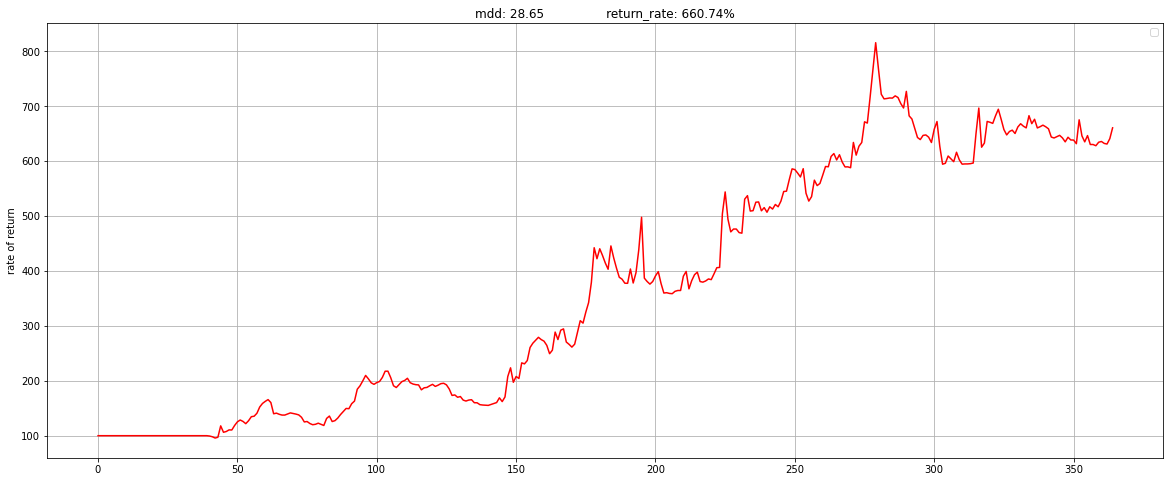

In [351]:
df_merge = merge_df(selected_list_df)
visualize_merge_df(df_merge)

In [ ]:
params = [(3, 2), (4, 2), (5, 3), (7, 4), (10, 5), (14, 7), (20, 10), (30, 15), (40, 20)]
result = turtle_backtest("KRW-XRP", "2021-11-09", 100, params)

for idx, param in enumerate(result):
    print(idx, ": ", param[0])